
Save and load datasets stored in TFRecord file format
=====================================================

This example demonstrates how to load the data from a stored .tfrecord file and to build a 
data generator.

## Save Dataset to TFRecord

At first, a small temporary dataset compounding 5 source cases is created by utilizing Dataset1. The conventional beamforming map is included by specifying `sourcemap` as the desired feature.    

In [9]:
import tensorflow as tf
from acoupipe.datasets.synthetic import DatasetSynthetic1

d1 = DatasetSynthetic1()      
d1.save_tfrecord(features=["sourcemap","loc","f"], f=2000, split="training", size=5, name="/tmp/dataset.tfrecord")

100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


## Load Dataset from TFRecord File 

To parse the data from TFRecord files it is usually necessary to write a custom parser function that parses the file sequentially
(see: TFRecord_ documentation for details).

A potential parser function for the `'sourcemap'` feature can be similar to:


In [8]:

def tfrecord_parser(record):
    """ parser for tfrecord datasets with 'csmtriu' feature """
    parsed = tf.io.parse_single_example(
        record, 
        {
        'sourcemap': tf.io.VarLenFeature(tf.float32),
        # and further features ...
        }
    )
    sourcemap = tf.reshape(tf.sparse.to_dense(parsed['sourcemap']),shape=(64,64))
    return {'sourcemap': sourcemap} # and further features ...

To ease the data retrieval process, the dataset itself provides a `get_tfrecord_parser` method to obtain a suitable parser function.

In [10]:
parser = d1.get_tfrecord_parser(features=["sourcemap","loc","f"], f=2000, num=0)

With the corresponding parser, one can load the Dataset with the TensorFlow Dataset API

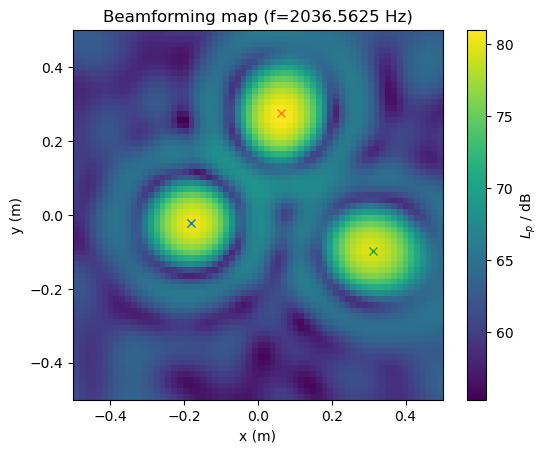

In [11]:
import acoular as ac
import matplotlib.pyplot as plt

dataset = tf.data.TFRecordDataset(
    filenames=["/tmp/dataset.tfrecord"],).map(parser)

# create an iterator from the dataset
dataset_iter = iter(dataset)
data = next(dataset_iter)

sourcemap = ac.L_p(data['sourcemap']).T
loc = data['loc']
f = data['f'][0]
extent = d1.config.grid.extend()

plt.figure()
plt.title(f"Beamforming map (f={f} Hz)")
plt.imshow(sourcemap,extent=extent,origin='lower')
for l in loc[:2].numpy().T:
    plt.plot(l[0],l[1],'x')
plt.colorbar(label=r'$L_p$ / dB')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()